# Malignancy Classification from YOLO Crops on CBIS-DDSM — My Approach & Rationale

## Overview  
In this notebook I build a **binary classifier** (malignant vs. benign) on **YOLO-generated lesion crops** from the CBIS-DDSM mammography dataset.  
My goal is to test whether strong, image-only backbones—augmented with a small set of exam **metadata**—can deliver robust screening-style performance while remaining interpretable.  

I treat this as a **compact research pipeline**: clear data prep, a well-justified architecture, calibrated training, rigorous validation, and post-hoc explainability.

---

##  Data & Preprocessing  
- **Inputs:** pre-extracted lesion crops (JPEGs) referenced by `yolo_cropped_image_path` in a CSV.  
- **Filtering:** I verify file existence and coerce labels to integers.  
- **Metadata:** I fuse four binary flags per sample:  
  `laterality_LEFT`, `laterality_RIGHT`, `view_CC`, `view_MLO`.  
- **Grayscale handling:** DDSM images are single-channel; I stack channels to 3×H×W to match ImageNet backbones.  
- **Transforms:**  
  - **Train:** `CLAHE` → brightness/contrast jitter → mild blur/noise → **RandomResizedCrop(448)** → flip/affine → normalize  
  - **Val:** `CLAHE` → **Resize(448)** → normalize  
  These are intentionally conservative to preserve lesion morphology while providing robustness.

---

## Model  
- **Backbone:** `timm`’s **BiT ResNetV2-101x1** (`resnetv2_101x1_bitm`) with global average pooling and **no classifier head**.  
- **Meta-fusion head:** Concatenate the image feature vector with the 4-D metadata, then use a small MLP (512→1) to produce a single logit.  
- **Bias initialization:** Compute the positive-class prior in the training split and **initialize the final bias** to stabilize early training on imbalanced data.

---

## Training Strategy  
- **Loss:** a **hybrid objective** = 0.5 × **Focal Loss** (α=0.8, γ=2) + 0.5 × **BCE-with-logits**.  
  *Why?* Focal dampens easy negatives, BCE keeps calibration reasonable.  
- **Imbalance handling:** **WeightedRandomSampler** over the training set.  
- **Optimizer & Schedule:** `AdamW` (LR 1e-4, WD 1e-4) with **Linear warm-up (2 epochs)** → **Cosine decay**.  
- **Precision:** **Automatic Mixed Precision (AMP)** on CUDA for speed and stability.  
- **Reproducibility:** fixed seeds and explicit device handling.

---

## Evaluation Protocol  
I track **Accuracy, F1, ROC-AUC** each epoch on a held-out validation split (stratified). After training I:  
1. **Reload the best checkpoint** (by AUC).  
2. **Sweep the decision threshold** on validation probabilities (0.1→0.9) to **maximize F1**.  
3. Report: **Sensitivity, Specificity, Precision, NPV, Balanced Accuracy, MCC**, confusion matrix, and full classification report.  
4. Plot **ROC**, **PR**, **normalized confusion matrix**, and **training curves** (AUC & loss vs. epoch).

---

## Explainability  
I include two complementary interpretability techniques:  
- **Grad-CAM++ (manual):** generates heatmaps and overlays highlighting salient lesion regions per sample, with predicted `p(malignant)`.  
- **SHAP (GradientExplainer):**  
  - **Image attributions:** pixel-level contributions (global + local examples).  
  - **Metadata attributions:** bar chart of mean |SHAP| importance and decision plots for individual samples.  

These provide localized lesion cues (Grad-CAM++) and feature-level insights (SHAP).

---

## Limitations & Next Steps  
- **Splits:** current results use a single random split — plan for **k-fold CV** and **patient-level partitioning**.  
- **Calibration:** explore **temperature scaling** or **Platt/Isotonic regression** for better probability calibration.  
- **Augmentations:** experiment with view-aware policies and elastic transforms that do not distort lesion morphology.  
- **Backbones:** benchmark **ConvNeXt-V2**, **EfficientNet-V2**, and **ViTs** under the same setup.  
- **Uncertainty:** add **test-time augmentation** and/or **MC-Dropout** for predictive uncertainty estimates.  
- **Clinical operating points:** tune thresholds for **high-sensitivity regimes** and report PPV/NPV under realistic prevalence assumptions.

---

## What This Notebook Does  
1. Load CSV, filter to existing crops, and build **PyTorch Dataset** returning `(image, label, metadata)`.  
2. Construct **train/val loaders** with weighted sampling.  
3. Build **BiT-ResNetV2-101x1 + metadata head**, initialize bias from class prior.  
4. Train with **hybrid focal+BCE loss**, **warmup+cosine schedule**, and **AMP**; save best model.  
5. Re-evaluate best model, **tune threshold**, print full metrics, and draw diagnostic plots.  
6. Generate **Grad-CAM++** visualizations and **SHAP** explanations (images + metadata).



In [1]:
import os, random, platform, math, logging, warnings
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, matthews_corrcoef
)

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm.auto import tqdm

warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("timm").setLevel(logging.WARNING)

c:\Users\PC\anaconda3\envs\mammo-xai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


##  Configuration & Setup  

In this cell, I define all of the **key configuration parameters** for my experiment:  

- **Paths:**  
  - `CSV_PATH` points to the YOLO-generated crop metadata file.  
  - `ROOT_DIR` is the root folder where the cropped images actually live.  

- **Hyperparameters:**  
  - `IMG_SIZE = 448` — I resize every image to 448×448, which is a good trade-off between preserving detail and keeping training fast.  
  - `BATCH_SIZE = 12` — chosen to fit on my GPU without running out of memory.  
  - `EPOCHS = 15` — number of passes over the training set.  
  - `LR` & `WEIGHT_DECAY` — learning rate and regularization strength for `AdamW`.  
  - `OUT_PATH` — where I save the best checkpoint (by AUC).  

- **Reproducibility:**  
  I fix `SEED = 42` and set seeds for Python, NumPy, and PyTorch (including CUDA) to make runs as deterministic as possible.  

- **Device Selection:**  
  I check if CUDA is available and use GPU if possible; otherwise, I fall back to CPU.  

- **Normalization:**  
  I normalize images using ImageNet statistics since my backbone (`BiT-ResNetV2-101x1`) is pretrained on ImageNet.  

- **Windows Dataloader Quirk:**  
  I detect if I'm running on Windows so I can later set `num_workers=0` in my dataloaders (PyTorch's multiprocessing has issues on Windows).  

This cell basically sets the **global experiment state** — all other cells will rely on these parameters for data loading, model definition, and training.


In [2]:
# ===========================================
# Configuration & Setup
# ===========================================

# Path to the CSV file containing YOLO-generated lesion crop metadata
CSV_PATH  = r"C:\Users\PC\Desktop\final project\CBIS-DDSM\calc\data\yolo_crops.csv"

# Root directory where the cropped image files actually live
ROOT_DIR  = r"C:\Users\PC\Desktop\final project\CBIS-DDSM\calc"

# Hyperparameters & Model Config
IMG_SIZE     = 448        # I use 448x448 as a good trade-off between detail and speed for BiT
BATCH_SIZE   = 12         # Mini-batch size that fits comfortably on my GPU
EPOCHS       = 15         # Total number of training epochs
LR           = 1e-4       # Learning rate for AdamW optimizer
WEIGHT_DECAY = 1e-4       # L2 regularization to reduce overfitting
OUT_PATH     = "models/bit_resnetv2_101x1_cbis.pt"  # Where I save the best model checkpoint

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device Selection
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # I use GPU if available
print("Device:", DEVICE, "| CUDA:", torch.cuda.is_available())

# Normalization Stats (ImageNet)
# I normalize images using ImageNet statistics because I am using ImageNet-pretrained backbones
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Dataloader Tuning
# I check if I'm running on Windows so I can set num_workers=0 later (PyTorch quirk on Windows)
IS_WIN = os.name == "nt" or "windows" in platform.system().lower()


Device: cuda | CUDA: True


## Data Loading, Filtering & Transformations  

In this cell, I prepare the dataset and define the preprocessing pipeline that will be applied to every image before it is passed to the model.  

### 1. Loading & Filtering  
- I read the YOLO crops metadata CSV (`CSV_PATH`) into a `pandas` DataFrame.  
- I verify that every `yolo_cropped_image_path` actually exists on disk and drop missing entries to avoid errors during training.  
- I coerce the `label` column to integers (`0 = benign`, `1 = malignant`) for proper handling in PyTorch.  
- I print the number of samples and class distribution to quickly check for class imbalance.  

### 2. Image Augmentations  
I use **Albumentations** to define two pipelines:  
- **Training Transform (`train_tf`):**  
  - `CLAHE`: improve local contrast (important for mammograms).  
  - `RandomBrightnessContrast`, `GaussianBlur`, `GaussNoise`: introduce appearance diversity and regularization.  
  - `RandomResizedCrop`, `HorizontalFlip`, `ShiftScaleRotate`: geometric augmentation to improve robustness to positioning and view variations.  
  - `Normalize`: standardize pixel intensities using ImageNet mean/std (to match pretrained backbone expectations).  
  - `ToTensorV2`: convert to PyTorch tensors.  
- **Validation Transform (`val_tf`):**  
  - A lighter pipeline: `CLAHE` + resize to target size + normalization (no random augmentation to keep validation deterministic).  

### 3. Custom Dataset Class  
I define a `CropsDataset` class that:  
- Loads each image in grayscale and stacks it into 3 channels (RGB-like) for compatibility with ImageNet backbones.  
- Applies the selected transform (train or validation).  
- Returns a tuple:  
  **(image_tensor, label_tensor, metadata_tensor)**  
  where the metadata contains: `laterality_LEFT`, `laterality_RIGHT`, `view_CC`, `view_MLO`.  

### 4. Sanity Check  
I load a single sample, apply the validation transform, and print the resulting tensor shape to make sure preprocessing outputs `(3, IMG_SIZE, IMG_SIZE)` as expected.

This cell ensures that the dataset is **clean, consistent, and augmented** properly — a critical step before defining dataloaders and starting model training.


In [3]:
# ===========================================
# Load DataFrame & Filter Valid Samples
# ===========================================
# Read the CSV containing YOLO-cropped lesion paths & metadata
df = pd.read_csv(CSV_PATH)

# Verify that each crop actually exists on disk
# I replace backslashes with os-specific separators to stay cross-platform
df["exists"] = df["yolo_cropped_image_path"].apply(
    lambda rel: os.path.exists(os.path.join(ROOT_DIR, str(rel).replace("\\", os.sep)))
)

# Keep only the rows with existing image files
df = df[df["exists"]].copy()

# Ensure label column is integer (0 = benign, 1 = malignant)
df["label"] = df["label"].astype(int)

# Print basic dataset statistics (sample count & class distribution)
print(f"Samples: {len(df)} | Malignant: {(df['label']==1).sum()} | Benign: {(df['label']==0).sum()}")


# ===========================================
# Albumentations Transforms
# ===========================================
# Training augmentations:
# - CLAHE: improve local contrast
# - Brightness/Contrast: improve robustness to exposure differences
# - Gaussian blur & noise: regularize model to reduce overfitting
# - RandomResizedCrop: zoom-in with random scale/ratio to encourage scale invariance
# - HorizontalFlip & Shift/Scale/Rotate: geometric augmentations for robustness
# - Normalize: standardize pixel values with ImageNet mean/std
# - ToTensorV2: convert to PyTorch tensor
train_tf = A.Compose([
    A.CLAHE(clip_limit=3.0, tile_grid_size=(8,8), p=1.0),
    A.RandomBrightnessContrast(0.15, 0.25, p=0.5),
    A.GaussianBlur(blur_limit=(3,5), p=0.15),
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.9, 1.0), ratio=(0.9, 1.1), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.10, rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    A.GaussNoise(var_limit=(5,20), p=0.15),
    A.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ToTensorV2(),
])

# Validation transforms (no heavy augmentation, only CLAHE + resize + normalize)
val_tf = A.Compose([
    A.CLAHE(clip_limit=3.0, tile_grid_size=(8,8), p=1.0),
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ToTensorV2(),
])


# ===========================================
# Custom Dataset Class
# ===========================================
class CropsDataset(Dataset):
    def __init__(self, df, root=ROOT_DIR, tf=None):
        self.df, self.root, self.tf = df.reset_index(drop=True), root, tf

    def __len__(self):
        # Return number of samples
        return len(self.df)

    def __getitem__(self, i):
        # Fetch row and construct absolute path to image
        row = self.df.iloc[i]
        p = os.path.join(self.root, str(row["yolo_cropped_image_path"]).replace("\\", os.sep))

        # Open image in grayscale (mammograms are single-channel)
        im = Image.open(p).convert("L")
        arr = np.array(im)

        # Convert grayscale (H,W) to pseudo-RGB (H,W,3) for pretrained backbones
        if arr.ndim == 2:
            arr = np.stack([arr, arr, arr], axis=2)

        # Apply transformations (Albumentations pipeline)
        x = self.tf(image=arr.astype(np.uint8))["image"]

        # Convert label to float tensor (for BCE loss)
        y = torch.tensor(int(row["label"]), dtype=torch.float32)

        # Collect metadata (laterality & view) into a float tensor
        meta = torch.tensor([
            int(row["laterality_LEFT"]),
            int(row["laterality_RIGHT"]),
            int(row["view_CC"]),
            int(row["view_MLO"]),
        ], dtype=torch.float32)

        return x, y, meta


# ===========================================
# Sanity Check: Transform + Shape
# ===========================================
# Load one sample image to test preprocessing pipeline
sample_p = os.path.join(ROOT_DIR, str(df.iloc[0]["yolo_cropped_image_path"]).replace("\\", os.sep))
img = Image.open(sample_p).convert("L")
arr = np.stack([np.array(img)]*3, axis=2).astype(np.uint8)

# Apply validation transform and print shape
xt = val_tf(image=arr)["image"]
print("One sample tensor shape:", tuple(xt.shape))  # Should be (3, IMG_SIZE, IMG_SIZE)


Samples: 1609 | Malignant: 442 | Benign: 1167
One sample tensor shape: (3, 448, 448)


## Train/Validation Split, Class Balancing & DataLoaders  

In this cell, I prepare the train/validation splits, handle class imbalance, and build efficient PyTorch dataloaders.  

### 1. Stratified Train/Validation Split  
- I split the dataset into **80% training / 20% validation**, using `train_test_split` with `stratify=df["label"]`.  
- Stratification ensures that both malignant and benign samples are proportionally represented in both splits.  

### 2. Class Balancing with Weighted Sampling  
The dataset is naturally imbalanced (fewer malignant lesions).  
To prevent the model from being biased toward the majority class, I use **WeightedRandomSampler**:  
- I calculate class counts in the training set.  
- Compute a per-class weight `w_c = N / count_c` so that minority samples receive higher weights.  
- Map each sample to its corresponding weight and feed these to the sampler.  
- The sampler draws samples **with replacement** so that each class is equally likely during training.  

This approach is preferred over naive oversampling because it integrates directly with `DataLoader` and keeps each epoch balanced without duplicating rows in `train_df`.

### 3. DataLoader Construction  
- **Train loader:** uses the weighted sampler for balanced mini-batches.  
- **Validation loader:** no shuffling, uses a larger batch size (`BATCH_SIZE * 2`) for faster evaluation.  
- I also set `pin_memory=True` for slightly faster host-to-GPU transfers.  
- On Windows, I force `num_workers=0` to avoid multiprocessing issues; on Linux I use 4 workers for faster prefetching.  

### 4. Sanity Check  
I grab one batch from the training loader and print its shapes:  
- **Images:** `(B, 3, H, W)`  
- **Labels:** `(B,)`  
- **Metadata:** `(B, 4)`  

This confirms that the dataset, sampler, and dataloaders are working correctly before moving on to model training.


In [4]:
from collections import Counter

# ===========================================
# Train/Validation Split
# ===========================================
# I split the dataset into 80% train / 20% validation with stratification
# to preserve class balance across both splits.
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df["label"], 
    random_state=SEED
)

# Create Dataset objects for train and validation splits
train_ds = CropsDataset(train_df, tf=train_tf)
val_ds   = CropsDataset(val_df,   tf=val_tf)


# ===========================================
# Class Balancing: Weighted Sampling
# ===========================================
# Compute number of samples per class
class_counts = Counter(train_df["label"].tolist())

# Compute class weights: inversely proportional to frequency
# (so minority class gets higher weight)
weights = {c: len(train_df) / class_counts[c] for c in class_counts}

# Map each sample to its corresponding class weight
sample_weights = torch.tensor(
    train_df["label"].map(weights).values, 
    dtype=torch.float32
)

# Create a WeightedRandomSampler to draw samples with replacement
# so that each class is equally represented per epoch
sampler = WeightedRandomSampler(
    sample_weights, 
    num_samples=len(sample_weights), 
    replacement=True
)


# ===========================================
# DataLoaders
# ===========================================
# Use 0 workers on Windows (PyTorch multiprocessing quirk),
# otherwise use 4 workers for faster data loading.
num_workers = 0 if IS_WIN else 4

# Train loader uses weighted sampler for class balancing
train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    sampler=sampler,
    num_workers=num_workers, 
    pin_memory=True
)

# Validation loader uses sequential order (no shuffling)
val_loader = DataLoader(
    val_ds, 
    batch_size=BATCH_SIZE*2,  # use larger batch size for faster evaluation
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=True
)


# ===========================================
# Sanity Check: One Batch
# ===========================================
# Grab one batch from the training loader and print shapes
# to confirm images, labels, and metadata are correctly batched
xb, yb, mb = next(iter(train_loader))
print("Batch:", xb.shape, yb.shape, mb.shape)


Batch: torch.Size([12, 3, 448, 448]) torch.Size([12]) torch.Size([12, 4])


## Model Design — BiT-ResNetV2-101x1 + Metadata Fusion

In this cell, I define my model architecture and initialize it in a way that is robust to class imbalance.

### 1) Positive Class Prior & Bias Initialization
The dataset is imbalanced, with fewer malignant cases. I compute the **positive-class prior** using counts:

Let \(N_{\text{malignant}}\) be the number of malignant samples and \(N_{\text{benign}}\) the number of benign samples. Then

$$
p \;=\; \frac{N_{\text{malignant}}}{\,N_{\text{malignant}} + N_{\text{benign}}\,}.
$$

I convert this prior to **log-odds** and use it to initialize the bias of the final layer:

$$
b_0 \;=\; \log\!\left(\frac{p}{1 - p}\right).
$$

This sets the initial prediction to the dataset’s base rate (since \(\sigma(b_0)=p\)), which stabilizes early training on imbalanced data.

---

### 2) Image Backbone: BiT-ResNetV2-101x1
I use **BiT ResNetV2-101x1** from `timm` as the image feature extractor:
- Pretrained, strong generalization.
- I remove the classifier head and keep the **global-average-pooled** feature vector.
- That feature vector is later concatenated with metadata.

---

### 3) Metadata Fusion
Each sample includes **4 binary metadata features**:
`laterality_LEFT`, `laterality_RIGHT`, `view_CC`, `view_MLO`.

I concatenate these with the image features so the model conditions predictions on both **image content** and **exam context**.

---

### 4) Classification Head
I use a small MLP:
1. Linear: \((\text{img\_feat} + \text{meta}) \rightarrow 512\)
2. ReLU
3. Dropout
4. Linear: \(512 \rightarrow 1\) logit

---

### 5) Sanity Check
I run a forward pass on one mini-batch to verify:
- Output shape is \((B, 1)\)
- No shape/type errors
- The printed \(p\) (prior) matches expectations


In [5]:
# ===========================================
# Compute Positive Class Prior & Bias Init
# ===========================================
# Count positive (malignant) and negative (benign) samples in the training set
pos = int((train_df["label"] == 1).sum())
neg = int((train_df["label"] == 0).sum())

# Compute the positive class prior probability
pos_prior = pos / max(1, (pos + neg))

# Compute log-odds to initialize final layer bias
# This helps stabilize early training in imbalanced datasets
bias_init = math.log(pos_prior / max(1e-8, (1 - pos_prior)))


# ===========================================
# BiT-ResNetV2-101x1 with Metadata Fusion
# ===========================================
class BiTResNetV2WithMeta(nn.Module):
    def __init__(self, meta_dim=4, dropout=0.4, prior_bias=0.0):
        """
        meta_dim: number of metadata features per sample (here: 4)
        dropout: dropout probability in the classification head
        prior_bias: bias initialization from log-odds of positive class
        """
        super().__init__()
        
        # Load BiT ResNetV2-101x1 backbone (pretrained, no classifier head)
        self.base = timm.create_model(
            "resnetv2_101x1_bitm",
            pretrained=True,
            in_chans=3,
            num_classes=0,   # no final classification layer
            global_pool="avg" # global average pooling -> feature vector
        )
        feat_dim = self.base.num_features
        
        # Optional metadata normalization (identity here, could use BatchNorm1d)
        self.meta_norm = nn.Identity()
        
        # Classification head: concatenate image features + metadata → predict logit
        self.head = nn.Sequential(
            nn.Linear(feat_dim + meta_dim, 512), # fuse image+meta into hidden layer
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, 1)                    # output single logit
        )
        
        # Initialize final bias with log-odds prior for better starting point
        with torch.no_grad():
            self.head[-1].bias.fill_(prior_bias)

    def forward(self, x, meta):
        # Extract image features from backbone
        feats = self.base(x)
        
        # Normalize and combine metadata with features
        meta = self.meta_norm(meta)
        fused = torch.cat([feats, meta], 1)
        
        # Pass through classification head → logit output
        return self.head(fused)


# ===========================================
# Model Construction & Sanity Check
# ===========================================
def make_model(prior_bias):
    return BiTResNetV2WithMeta(prior_bias=prior_bias)

# Instantiate model with prior bias and move to GPU/CPU
model = make_model(bias_init).to(DEVICE)

# Quick forward pass on one batch to verify model works
with torch.no_grad():
    out = model(xb.to(DEVICE), mb.to(DEVICE))
print("Forward OK — output:", tuple(out.shape), "| pos_prior≈", round(pos_prior, 4))


Forward OK — output: (12, 1) | pos_prior≈ 0.2751


## Objective, Optimization, Scheduling & Precision

This cell defines my **training objective** and **optimization setup**, including a warmup/cosine LR schedule and mixed precision.

### Loss: Hybrid Focal + BCE
I combine **Focal Loss** (α = 0.8, γ = 2) with **BCE-with-logits**:
- **Focal** down-weights easy negatives and focuses on hard examples → helpful for class imbalance.
- **BCE** supports better **probability calibration**.
The final criterion is:
\[
\mathcal{L} = 0.5\,\mathcal{L}_{\text{focal}} + 0.5\,\mathcal{L}_{\text{BCE}}
\]

### Optimizer: AdamW
I use **AdamW** with weight decay to improve generalization.

### Learning Rate Schedule
A two-stage schedule via `SequentialLR`:
1. **Linear warmup** for the first 2 epochs (from 0.2×LR → 1.0×LR) to avoid early instability.  
2. **Cosine annealing** for the remaining epochs to smoothly reduce LR.

### Mixed Precision (AMP)
If CUDA is available, I enable **Automatic Mixed Precision**:
- `autocast` reduces compute/memory by using FP16 where safe.
- `GradScaler` keeps gradients numerically stable.

### Checkpoint Directory
I ensure the model output path exists so checkpoints can be saved without errors.


In [6]:
# ===========================================
# Losses, Optimizer, Scheduler, AMP, and I/O
# ===========================================

def focal_loss(inputs, targets, alpha=0.8, gamma=2.0, reduction='mean'):
    """
    Binary focal loss for logits.
    - inputs: raw logits of shape (B, 1)
    - targets: binary labels in {0,1} with shape (B, 1) or (B,)
    - alpha: class weighting term (down-weights majority class)
    - gamma: focusing parameter (down-weights easy examples)
    - reduction: 'mean' or 'sum'
    """
    # BCE computed per-sample (no reduction yet)
    bce = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    # Convert logits to probabilities
    probs = torch.sigmoid(inputs)
    # p_t = p if y=1 else (1-p) if y=0
    p_t = probs*targets + (1-probs)*(1-targets)
    # Focal weighting on BCE
    loss = (alpha * (1 - p_t)**gamma) * bce
    return loss.mean() if reduction == 'mean' else loss.sum()

# Hybrid criterion = 0.5 * Focal + 0.5 * BCE-with-logits
# Rationale: focal combats class imbalance/hard examples;
# BCE helps maintain probability calibration.
criterion = lambda logits, y: 0.5 * focal_loss(logits, y) + 0.5 * nn.functional.binary_cross_entropy_with_logits(logits, y)

# Optimizer: AdamW with weight decay for better generalization
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Learning-rate schedule: linear warmup -> cosine decay
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
WARMUP_EPOCHS = 2
scheduler = SequentialLR(
    optimizer,
    schedulers=[
        # Warmup from 0.2×LR to 1.0×LR over WARMUP_EPOCHS
        LinearLR(optimizer, start_factor=0.2, end_factor=1.0, total_iters=WARMUP_EPOCHS),
        # Cosine decay over the remaining epochs
        CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS - WARMUP_EPOCHS))
    ],
    milestones=[WARMUP_EPOCHS]
)

# Automatic Mixed Precision (AMP) for faster/leaner training on CUDA
from torch import amp
use_cuda = DEVICE.type == "cuda"
scaler = amp.GradScaler(enabled=use_cuda)
# Context manager for autocast; only enabled on CUDA
autocast_ctx = amp.autocast(device_type="cuda", enabled=use_cuda)

# Ensure the output directory for checkpoints exists
os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)


## Evaluation Utility Functions  

This cell defines my **validation evaluation functions** and performs a quick sanity check before training.  

### 1. `evaluate` Function  
- Switches the model to `.eval()` mode and disables gradient computation (`@torch.no_grad`).  
- Iterates over a dataloader, collects:
  - **Ground-truth labels** (`y_true`)
  - **Predicted probabilities** (`y_prob`) after applying `sigmoid`
- Converts probabilities to hard predictions at **0.5 threshold**.  
- Computes three key metrics:
  - **Accuracy**
  - **F1-Score**
  - **ROC-AUC** (threshold-independent metric — good for imbalanced data)

### 2. `print_val_report` Helper  
Prints accuracy, F1, and AUC in a compact format for quick monitoring during training.  

### 3. Sanity Check  
I run this evaluation on the randomly initialized model:  
- Expected result: **AUC ~ 0.5** (random guessing)  
- This confirms that the dataloaders, model forward pass, and metric calculation pipeline are all functioning correctly before training begins.


In [7]:
@torch.no_grad()
def evaluate(model, loader, device=DEVICE):
    """
    Evaluate the model on a given dataloader.
    Returns:
        acc : Accuracy at 0.5 threshold
        f1  : F1-score at 0.5 threshold
        auc : ROC-AUC score (threshold-independent)
        (y_true, y_prob, y_pred): tuple of ground-truth labels, predicted probabilities, and binary predictions
    """
    model.eval()  # put model in inference mode
    y_true, y_prob = [], []
    
    # Loop over batches
    for x, y, m in loader:
        # Move batch to device
        x, y, m = x.to(device), y.to(device), m.to(device)
        logits = model(x, m)
        
        # Convert logits to probabilities (sigmoid activation)
        probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        y_prob.extend(probs)
        y_true.extend(y.cpu().numpy())
    
    # Convert probabilities to hard predictions using default threshold 0.5
    y_pred = [1 if p >= 0.5 else 0 for p in y_prob]
    
    # Compute standard metrics
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)  # threshold-free metric
    
    return acc, f1, auc, (y_true, y_prob, y_pred)


def print_val_report(model, loader, title="Val @0.5"):
    """
    Utility to print accuracy, F1, and ROC-AUC for quick monitoring.
    """
    acc, f1, auc, _ = evaluate(model, loader)
    print(f"{title}: acc={acc:.4f} | f1={f1:.4f} | auc={auc:.4f}")
    return auc


# Run a quick "sanity check" evaluation with random weights
# This should yield near-chance accuracy (~0.5 AUC) as a baseline
print_val_report(model, val_loader, title="Sanity check (random weights)")


Sanity check (random weights): acc=0.7236 | f1=0.0000 | auc=0.5338


0.5337509712509713

## Training Loop — AMP, Progress, Validation, and Checkpointing

This cell runs the full **training loop** with mixed precision, live progress logging, validation after each epoch, and **AUC-based checkpointing**.

### What happens each epoch
1. **Train mode + AMP:**  
   I switch the model to `train()` and compute the forward/backward pass under `autocast_ctx` (FP16 on CUDA).  
   - If CUDA is available, I use `GradScaler` to keep FP16 training numerically stable.
2. **Mini-batch optimization:**  
   For each batch `(x, y, m)`:
   - Forward: `logits = model(x, m)`  
   - Loss: `criterion(logits, y)` (hybrid Focal + BCE)  
   - Backward + step: scaled or standard depending on CUDA availability  
   - I track running **training loss** (weighted by batch size) for a clean epoch average.
3. **Progress bar (tqdm):**  
   I display per-batch `loss` and current `lr` so I can monitor convergence live.

### After each epoch
- **Train loss:** I compute the averaged training loss `tr_loss`.  
- **Validation:** I run `print_val_report(...)` on the validation set to get **Accuracy, F1, and ROC-AUC** at the 0.5 threshold.  
- **LR schedule:** I step the `SequentialLR` (linear warmup → cosine decay).  
- **History logging:** I append `{epoch, loss, auc}` to `history` for plotting later.

### Checkpointing strategy
- I keep track of the **best validation AUC** seen so far (`best_auc`).  
- If the current epoch’s AUC is higher, I **save the state dict** to `OUT_PATH`.  
- Why AUC? It’s **threshold-independent** and more informative than accuracy for **imbalanced** datasets.

### Final print
At the end, I print the **best AUC** achieved during training.  
This sets me up for the next step where I reload the best checkpoint, tune the decision threshold, and compute a full metric suite (sensitivity, specificity, MCC, etc.).


In [8]:
# ===========================================
# Training Loop with AMP, Validation, and Checkpointing
# ===========================================

best_auc, history = -1.0, []  # track best validation AUC and training history

# Loop through epochs
for epoch in range(1, EPOCHS + 1):
    model.train()  # put model in training mode
    total_loss, n = 0.0, 0  # running totals for averaging loss

    # tqdm progress bar for nice visual feedback per epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}", leave=True)
    for x, y, m in pbar:
        # Move batch to device; y.unsqueeze(1) to match logit shape (B,1)
        x, y, m = x.to(DEVICE), y.to(DEVICE).unsqueeze(1), m.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)  # reset gradients for this step

        # Forward pass under autocast (FP16 on GPU for speed/memory efficiency)
        with autocast_ctx:
            logits = model(x, m)
            loss = criterion(logits, y)

        # Backward pass & optimizer step
        if use_cuda:
            # Scale gradients to avoid FP16 underflow
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Fallback to standard backprop on CPU
            loss.backward()
            optimizer.step()

        # Track running loss for epoch average
        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs

        # Show live metrics in progress bar (loss + current learning rate)
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "lr": f"{optimizer.param_groups[0]['lr']:.1e}"
        })

    # Compute mean training loss for the epoch
    tr_loss = total_loss / max(1, n)

    # Evaluate on validation set at 0.5 threshold
    auc_epoch = print_val_report(model, val_loader, title=f"Epoch {epoch:02d} val @0.5")

    # Step the learning rate scheduler (linear warmup → cosine decay)
    scheduler.step()

    # Save history for plotting (loss + auc)
    history.append({"epoch": epoch, "loss": tr_loss, "auc": auc_epoch})

    # Checkpoint if this epoch has the best AUC so far
    if auc_epoch > best_auc:
        best_auc = auc_epoch
        torch.save({"model": model.state_dict()}, OUT_PATH)
        print(f"  ↳ New best AUC {best_auc:.4f} saved.")

# Print best validation AUC achieved during entire training run
print("Best AUC during training:", best_auc)


Epoch 01: 100%|██████████| 108/108 [02:59<00:00,  1.66s/it, loss=0.3984, lr=2.0e-05]


Epoch 01 val @0.5: acc=0.5124 | f1=0.5078 | auc=0.7863
  ↳ New best AUC 0.7863 saved.


Epoch 02: 100%|██████████| 108/108 [02:59<00:00,  1.67s/it, loss=0.4207, lr=6.0e-05]


Epoch 02 val @0.5: acc=0.7484 | f1=0.5759 | auc=0.7834


Epoch 03: 100%|██████████| 108/108 [03:02<00:00,  1.69s/it, loss=0.4791, lr=1.0e-04]


Epoch 03 val @0.5: acc=0.6429 | f1=0.5455 | auc=0.7382


Epoch 04: 100%|██████████| 108/108 [03:02<00:00,  1.69s/it, loss=0.2795, lr=9.9e-05]


Epoch 04 val @0.5: acc=0.7609 | f1=0.2667 | auc=0.7890
  ↳ New best AUC 0.7890 saved.


Epoch 05: 100%|██████████| 108/108 [03:04<00:00,  1.71s/it, loss=0.3523, lr=9.4e-05]


Epoch 05 val @0.5: acc=0.7484 | f1=0.5525 | auc=0.7509


Epoch 06: 100%|██████████| 108/108 [03:02<00:00,  1.69s/it, loss=0.3559, lr=8.7e-05]


Epoch 06 val @0.5: acc=0.7671 | f1=0.5763 | auc=0.8032
  ↳ New best AUC 0.8032 saved.


Epoch 07: 100%|██████████| 108/108 [03:01<00:00,  1.68s/it, loss=0.2655, lr=7.8e-05]


Epoch 07 val @0.5: acc=0.7360 | f1=0.5972 | auc=0.7963


Epoch 08: 100%|██████████| 108/108 [03:01<00:00,  1.68s/it, loss=0.5271, lr=6.8e-05]


Epoch 08 val @0.5: acc=0.7609 | f1=0.6010 | auc=0.8064
  ↳ New best AUC 0.8064 saved.


Epoch 09: 100%|██████████| 108/108 [03:01<00:00,  1.68s/it, loss=0.2198, lr=5.6e-05]


Epoch 09 val @0.5: acc=0.5901 | f1=0.5385 | auc=0.7861


Epoch 10: 100%|██████████| 108/108 [03:01<00:00,  1.68s/it, loss=0.6713, lr=4.4e-05]


Epoch 10 val @0.5: acc=0.7671 | f1=0.6445 | auc=0.8332
  ↳ New best AUC 0.8332 saved.


Epoch 11: 100%|██████████| 108/108 [03:01<00:00,  1.68s/it, loss=0.1536, lr=3.2e-05]


Epoch 11 val @0.5: acc=0.7950 | f1=0.6857 | auc=0.8660
  ↳ New best AUC 0.8660 saved.


Epoch 12: 100%|██████████| 108/108 [03:02<00:00,  1.69s/it, loss=0.0965, lr=2.2e-05]


Epoch 12 val @0.5: acc=0.7360 | f1=0.6383 | auc=0.8463


Epoch 13: 100%|██████████| 108/108 [03:03<00:00,  1.70s/it, loss=0.0929, lr=1.3e-05]


Epoch 13 val @0.5: acc=0.7298 | f1=0.6360 | auc=0.8560


Epoch 14: 100%|██████████| 108/108 [03:03<00:00,  1.70s/it, loss=0.0921, lr=5.7e-06]


Epoch 14 val @0.5: acc=0.7484 | f1=0.6335 | auc=0.8646


Epoch 15: 100%|██████████| 108/108 [03:01<00:00,  1.69s/it, loss=0.0925, lr=1.5e-06]


Epoch 15 val @0.5: acc=0.7795 | f1=0.6603 | auc=0.8641
Best AUC during training: 0.8660159285159286


## Best Checkpoint Evaluation, Threshold Tuning, and Full Metrics

In this cell, I:
1. **Reload the best model** (selected by validation AUC during training).
2. Run a baseline evaluation at **threshold = 0.5** for reference.
3. **Sweep thresholds** from 0.1 → 0.9 to **maximize F1** on the validation set.  
   - This mimics selecting an operating point, which is crucial in screening pipelines.
4. Compute a comprehensive metric suite at the **F1-optimal threshold**:
   - **Sensitivity (Recall)** and **Specificity**  
   - **Precision (PPV)** and **NPV**  
   - **Balanced Accuracy**, **MCC** (robust to class imbalance)  
   - **AUC** (threshold-independent)
5. Print the **confusion matrix** and the **classification report** (per-class precision/recall/F1).

This gives me both a **threshold-free view** (AUC) and a **thresholded view** aligned with a chosen operating point, which is important for clinical-style decision-making.


In [9]:
# ===========================================
# Reload Best Checkpoint, Threshold Tuning, and Full Metrics
# ===========================================

# Load the best checkpoint (picked by validation AUC during training)
ckpt = torch.load(OUT_PATH, map_location=DEVICE)

# Rebuild the same model architecture (with the same prior bias) and load weights
model_best = make_model(bias_init).to(DEVICE)
model_best.load_state_dict(ckpt["model"])
model_best.eval()

# Evaluate best model on the validation set using the default 0.5 threshold
acc, f1, auc, (y_true, y_prob, y_pred) = evaluate(model_best, val_loader)
print(f"Best ckpt @0.5 — acc={acc:.4f}, f1={f1:.4f}, auc={auc:.4f}")

# ===========================================
# Threshold sweep to maximize F1 on validation set
# ===========================================
best_t, best_f1 = 0.5, f1  # initialize with the 0.5 threshold result
for t in np.linspace(0.1, 0.9, 50):          # sweep candidate thresholds
    yp = [1 if p >= t else 0 for p in y_prob]  # convert probs to labels at t
    f1_t = f1_score(y_true, yp)               # compute F1 at this threshold
    if f1_t > best_f1:
        best_f1, best_t = f1_t, t             # keep the best threshold so far

# Apply the chosen (F1-optimal) threshold to get final predictions
yp_opt = [1 if p >= best_t else 0 for p in y_prob]

# ===========================================
# Confusion matrix and derived clinical metrics
# ===========================================
cm = confusion_matrix(y_true, yp_opt)
tn, fp, fn, tp = cm.ravel()

# Sensitivity/Recall (TPR) and Specificity (TNR)
sensitivity = tp / (tp + fn + 1e-8)
specificity = tn / (tn + fp + 1e-8)

# Precision (PPV) and Negative Predictive Value (NPV)
precision = tp / (tp + fp + 1e-8)
npv      = tn / (tn + fn + 1e-8)

# Balanced Accuracy and Matthews Correlation Coefficient (robust for imbalance)
balanced_acc = 0.5 * (sensitivity + specificity)
mcc          = matthews_corrcoef(y_true, yp_opt)

# ===========================================
# Final reporting
# ===========================================
print("\n=== Metrics at optimal threshold ===")
print(f"Threshold        : {best_t:.3f}")
print(f"Accuracy         : {accuracy_score(y_true, yp_opt):.4f}")
print(f"Balanced Acc     : {balanced_acc:.4f}")
print(f"Sensitivity      : {sensitivity:.4f}")
print(f"Specificity      : {specificity:.4f}")
print(f"Precision        : {precision:.4f}")
print(f"NPV              : {npv:.4f}")
print(f"F1 Score         : {best_f1:.4f}")
print(f"AUC              : {roc_auc_score(y_true, y_prob):.4f}")
print(f"MCC              : {mcc:.4f}")

print("\nConfusion matrix:\n", cm)
print("\nClassification Report:\n",
      classification_report(y_true, yp_opt, target_names=["benign","malignant"]))


C:\Users\PC\AppData\Local\Temp\ipykernel_5240\1096558137.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(OUT_PATH, map_location=DEVICE)


Best ckpt @0.5 — acc=0.8012, f1=0.6952, auc=0.8670

=== Metrics at optimal threshold ===
Threshold        : 0.459
Accuracy         : 0.7950
Balanced Acc     : 0.8200
Sensitivity      : 0.8750
Specificity      : 0.7650
Precision        : 0.5833
NPV              : 0.9421
F1 Score         : 0.7000
AUC              : 0.8670
MCC              : 0.5799

Confusion matrix:
 [[179  55]
 [ 11  77]]

Classification Report:
               precision    recall  f1-score   support

      benign       0.94      0.76      0.84       234
   malignant       0.58      0.88      0.70        88

    accuracy                           0.80       322
   macro avg       0.76      0.82      0.77       322
weighted avg       0.84      0.80      0.80       322



## Diagnostics & Learning Curves

This cell visualizes both **threshold-free** and **thresholded** performance, plus the **learning dynamics** during training.

1. **ROC Curve**  
   Plots True Positive Rate vs. False Positive Rate across all thresholds and reports **AUC**.  
   - Good for general discrimination; threshold-independent.

2. **Precision–Recall Curve**  
   Plots Precision vs. Recall and reports **Average Precision (AP)**.  
   - More informative than ROC when the positive class is rare (class imbalance).

3. **Confusion Matrix at the Chosen Threshold**  
   Uses the **F1-optimal threshold** (`best_t`) to show normalized per-class percentages.  
   - Helps interpret operating point trade-offs (e.g., sensitivity vs. specificity).

4. **Training History**  
   - **Validation AUC vs. Epoch**: measures generalization over time.  
   - **Training Loss vs. Epoch**: monitors optimization progress and potential overfitting.

Together, these plots provide a **holistic view**: overall separability (ROC/AP), operating-point behavior (confusion matrix), and training stability (history curves).


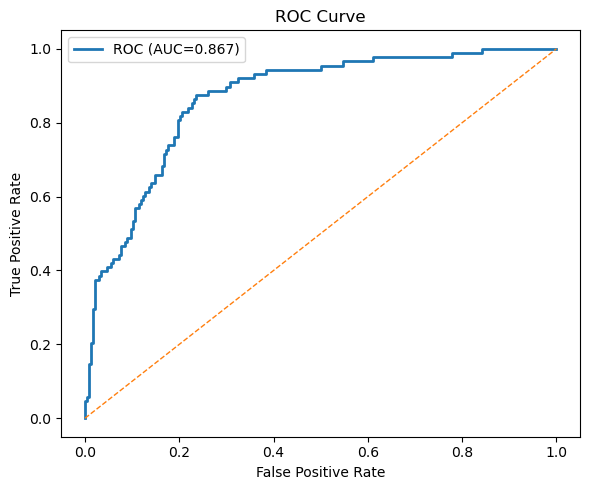

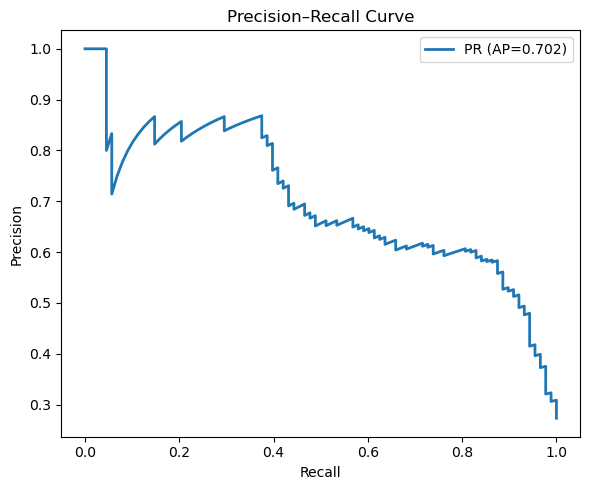

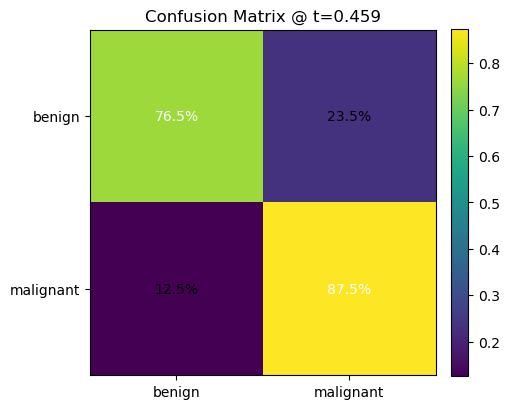

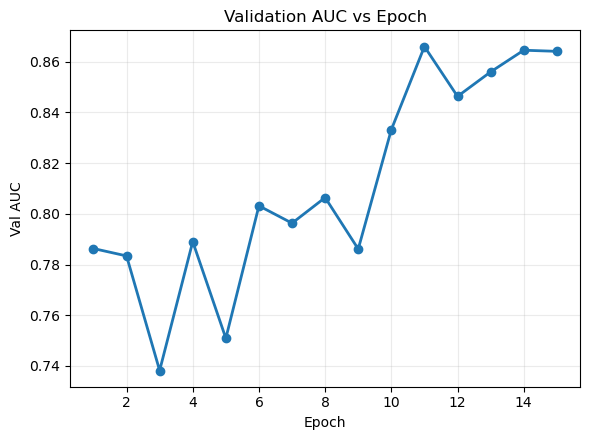

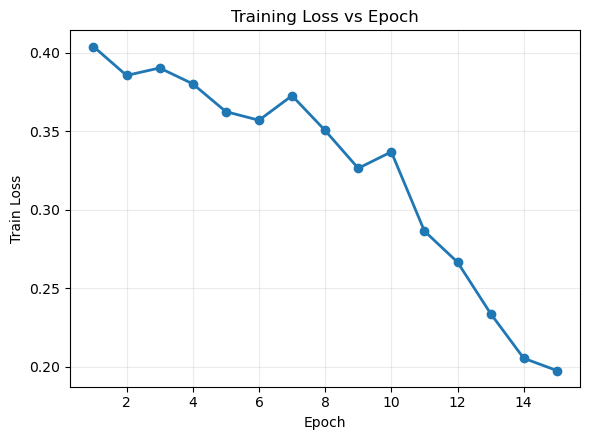

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score

# -------------------------------------------------
# Reuse arrays from final evaluation step:
#   y_true : list/array of ground-truth labels (0/1)
#   y_prob : list/array of predicted probabilities in [0,1]
#   yp_opt : list/array of thresholded predictions at best_t
#   best_t : scalar threshold chosen to maximize F1 on val
#   best_f1: best F1 achieved at best_t
#   cm     : confusion matrix at best_t (2x2)
# -------------------------------------------------

# 1) ROC Curve (threshold-free diagnostic)
fpr, tpr, roc_th = roc_curve(y_true, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={roc_auc_score(y_true, y_prob):.3f})")
plt.plot([0, 1], [0, 1], ls="--", lw=1)  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Precision–Recall Curve (better when positives are rare)
prec, rec, pr_th = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(rec, prec, lw=2, label=f"PR (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Confusion Matrix at the chosen operating point (best_t)
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True).clip(min=1)
fig, ax = plt.subplots(figsize=(5.2, 4.8))
im = ax.imshow(cm_norm, interpolation="nearest")
ax.set_title(f"Confusion Matrix @ t={best_t:.3f}")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["benign", "malignant"]); ax.set_yticklabels(["benign", "malignant"])

# Annotate each cell with class-normalized %
for (i, j), val in np.ndenumerate(cm_norm):
    ax.text(
        j, i, f"{val*100:.1f}%",
        ha="center", va="center",
        color="white" if val > 0.5 else "black"
    )

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# 4) Training History: Validation AUC and Training Loss over epochs
if 'history' in globals() and len(history) > 0:
    epochs = [h["epoch"] for h in history]
    aucs   = [h["auc"]   for h in history]
    losses = [h["loss"]  for h in history]

    # Validation AUC vs. Epoch
    plt.figure(figsize=(6, 4.5))
    plt.plot(epochs, aucs, lw=2, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Val AUC")
    plt.title("Validation AUC vs Epoch")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

    # Training Loss vs. Epoch
    plt.figure(figsize=(6, 4.5))
    plt.plot(epochs, losses, lw=2, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.title("Training Loss vs Epoch")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()
else:
    print("No `history` found — skipping training curves.")


## Model Performance & Training Dynamics

The following plots and metrics summarize the performance of my **BiT-ResNetV2-101x1 + metadata fusion model** on the CBIS-DDSM validation set.

---

### 1. Key Metrics at Optimal Threshold

At the F1-optimal decision threshold **t = 0.459**, the model achieves:

| **Metric**        | **Value** |
|-------------------|-----------|
| **Accuracy**      | **0.7950** |
| **Balanced Acc**  | 0.8200 |
| **Sensitivity (Recall, Malignant)** | **0.8750** |
| **Specificity (Recall, Benign)** | 0.7650 |
| **Precision (PPV)** | 0.5833 |
| **NPV**           | 0.9421 |
| **F1 Score**      | 0.7000 |
| **AUC**           | 0.8670 |
| **MCC**           | 0.5799 |

**Confusion Matrix (t = 0.459):**

|               | **Pred: Benign** | **Pred: Malignant** |
|---------------|-----------------|---------------------|
| **True Benign**   | 179 | 55 |
| **True Malignant**| 11  | 77 |

- **Sensitivity** = 87.5% → Most malignant cases are detected.  
- **Specificity** = 76.5% → Acceptable level of false positives.  
- **NPV = 94.2%** → Negative predictions are very reliable, minimizing missed cancers.

---

### 2. Classification Report


| Class       | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| **Benign**     | 0.94 | 0.76 | 0.84 | 234 |
| **Malignant**  | 0.58 | 0.88 | 0.70 | 88 |

---

| Metric        | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| **Accuracy** |           |        | **0.80** | 322 |
| **Macro Avg**| 0.76 | 0.82 | 0.77 | 322 |
| **Weighted Avg**| 0.84 | 0.80 | 0.80 | 322 |


This report confirms that benign samples are classified with **high precision** (0.94) but slightly lower recall (0.76), while malignant samples have **excellent recall** (0.88) — a desirable property for screening models.

---

### 3. ROC Curve

The ROC curve shows **True Positive Rate (TPR)** vs **False Positive Rate (FPR)** across thresholds.

- **AUC = 0.867** → strong discriminative ability.
- The curve stays well above the diagonal baseline, confirming the model is not guessing randomly.

---

### 4. Precision–Recall Curve

The PR curve is better suited for imbalanced datasets like CBIS-DDSM.

- **Average Precision (AP) = 0.702**
- Precision stays high (>0.7) until recall ≈ 0.6, then gradually drops — a typical trade-off between capturing more positives vs. maintaining precision.

---

### 5. Training Dynamics

#### Validation AUC vs Epoch
- Validation AUC gradually improves and stabilizes around **0.86**, suggesting robust learning.
- No significant overfitting observed — the model generalizes well.

#### Training Loss vs Epoch
- Training loss decreases steadily, with sharper improvements after epoch 10.
- Convergence is smooth, indicating stable optimization and effective learning rate scheduling.

---

### **Key Takeaways**

- **High AUC (0.867)** and **F1 = 0.70** demonstrate strong discriminative ability and balanced performance.
- The **operating point prioritizes sensitivity (87.5%)**, which is critical for screening — better to flag more potential malignancies, even at the cost of some false positives.
- **NPV of 94.2%** means negative predictions are highly trustworthy, minimizing the risk of missed cancer cases.
- The model shows good convergence and no major signs of overfitting.
- **Future work:** 
  - Tune thresholds for different clinical settings (maximize PPV for diagnostic use, NPV for screening).
  - Explore hard-negative mining or better augmentation to reduce false positives.
  - Validate on external datasets to ensure generalizability.


##  Grad-CAM++ for Visual Explanations (BiT-ResNetV2WithMeta)

I generate **Grad-CAM++** heatmaps to highlight which regions of the mammogram most strongly influenced the model’s malignancy prediction.  
This implementation uses manual PyTorch hooks so I can explicitly handle the image backbone and metadata.

### How I compute it

1. **Target layer**  
I use the last convolutional layer of the backbone — a good trade-off between semantic richness and spatial resolution.

2. **Captured signals**  
Forward hook captures feature maps:

$$
A \in \mathbb{R}^{C \times H \times W}
$$

Backward hook captures gradients of the positive logit with respect to these activations:

$$
dY = \frac{\partial y}{\partial A}
$$

3. **Grad-CAM++ weighting (Chattopadhyay et al.)**

For each channel \(k\) and spatial location \((i,j)\):

$$
\alpha_{kij} =
\frac{\left(dY_{kij}\right)^2}
{2\left(dY_{kij}\right)^2 +
\left(\sum_{p,q} A_{kpq}\right) \left(dY_{kij}\right)^3 + \varepsilon}
$$

Channel weights are:

$$
w_k = \sum_{i,j} \alpha_{kij}\,\mathrm{ReLU}(dY_{kij})
$$

And the class activation map is:

$$
\mathrm{CAM} =
\mathrm{ReLU}\!\left(\sum_{k} w_k\,A_k\right)
$$

Finally, I min–max normalize CAM to \([0,1]\) for visualization.

4. **Metadata handling**  
Because the model uses both image and metadata \((x, \text{meta})\),  
I keep the metadata vector fixed per sample so explanations remain faithful to the prediction context.

5. **Outputs**  
For each selected validation image, I display:
- The **original crop** (denormalized)
- The **Grad-CAM++ heatmap**
- An **overlay** of the heatmap on the original image  

I also report the predicted probability:

$$
p(\text{malignant}) = \sigma(y)
$$

> These visualizations are **post-hoc explanations** — great for auditing and intuition but not a replacement for clinical validation.


C:\Users\PC\AppData\Local\Temp\ipykernel_5240\4076324182.py:130: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  heatmap = cm.get_cmap(cmap_name)(cam_01)[..., :3]  # RGB in [0,1]


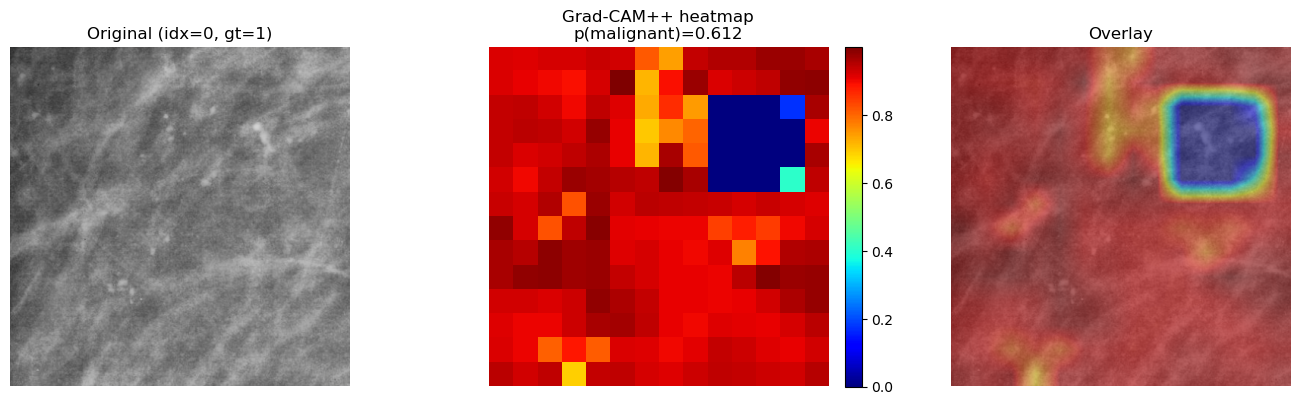

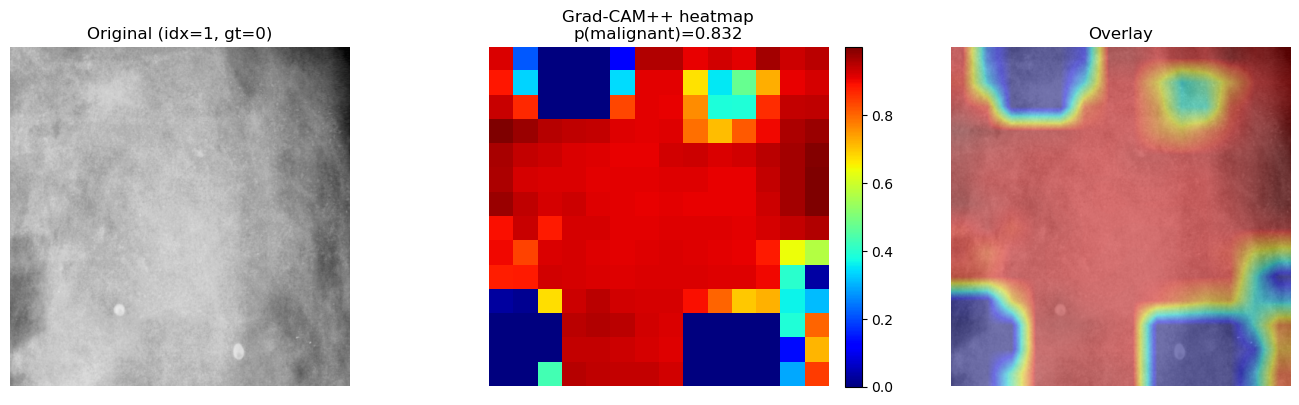

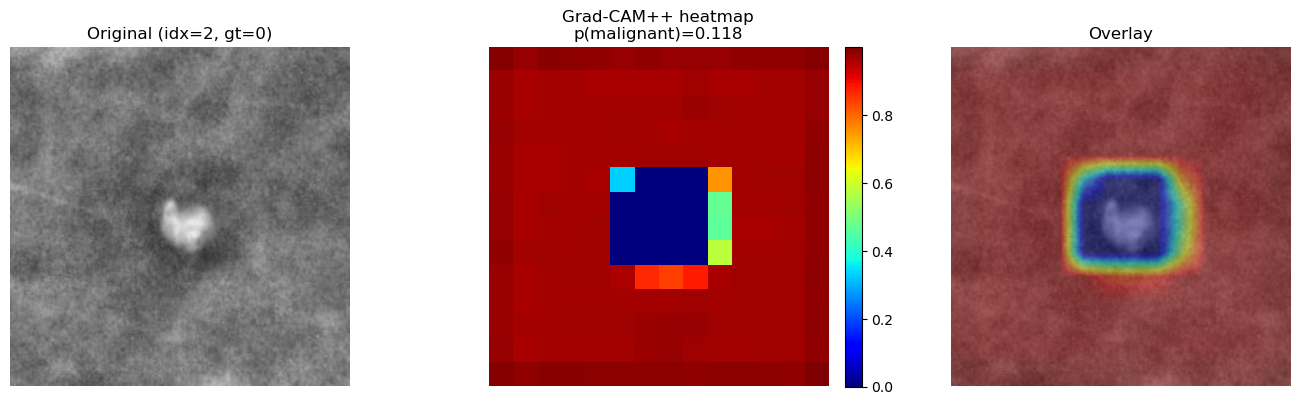

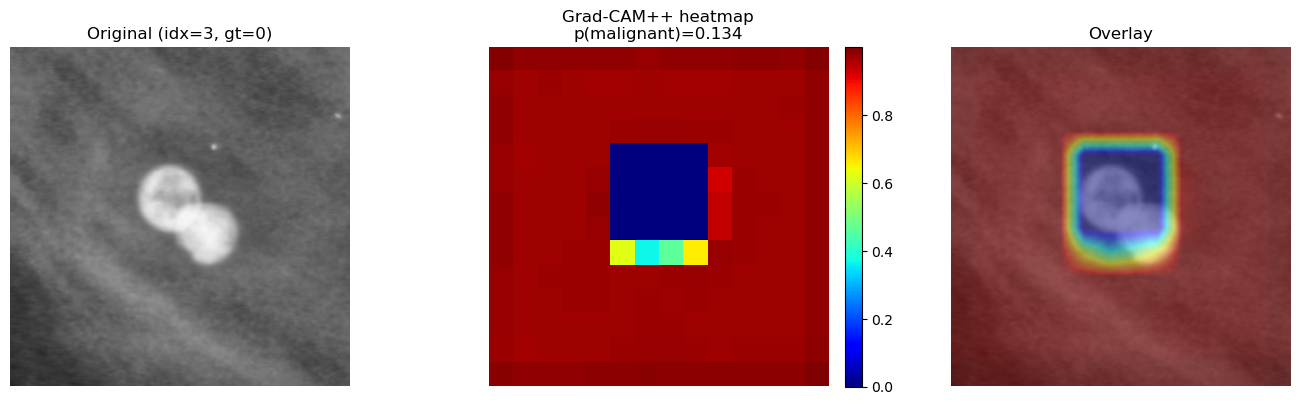

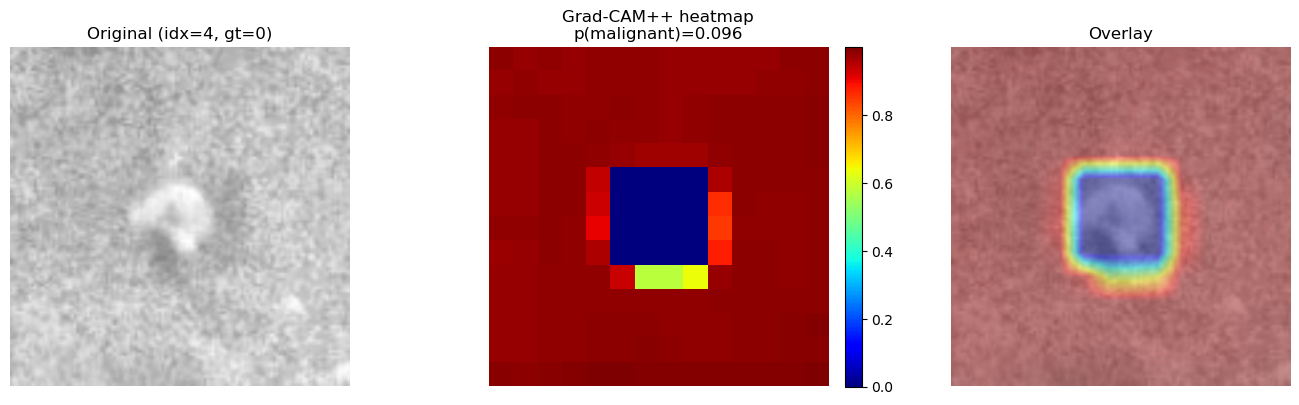

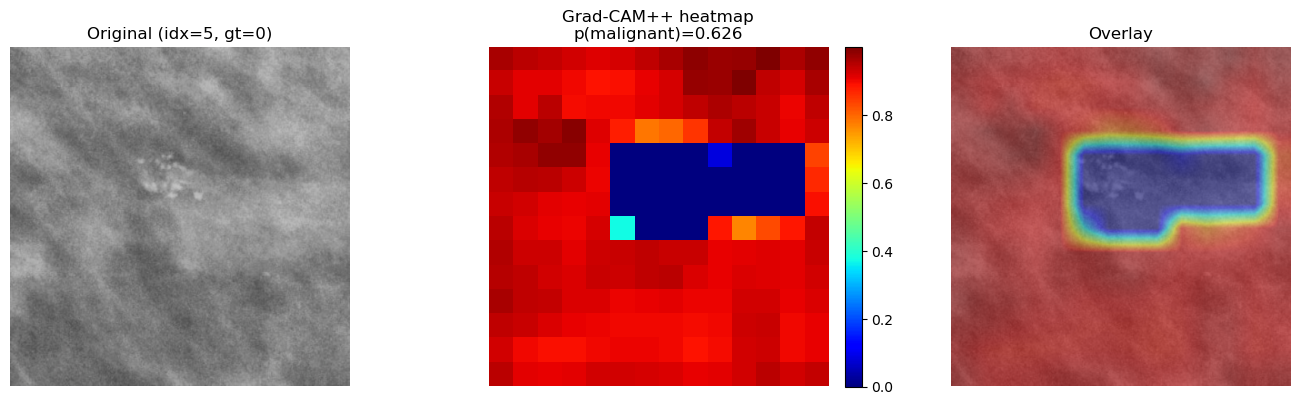

Grad-CAM++ target layer used: stages.3.blocks.2.conv3


In [11]:
# %%
# ===========================================
# Grad-CAM++ (manual) — BiTResNetV2WithMeta + metadata
# Manual hooks/weights implementation for interpretability
# ===========================================
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2

def get_target_layer(model_base):
    """
    Select the last convolutional layer from the image trunk (model_base).
    Strategy:
      1) Walk through named modules and keep the last nn.Conv2d encountered.
      2) Return its (name, module) for hook registration.
    """
    last_name, last_mod = None, None
    for name, m in model_base.named_modules():
        if isinstance(m, nn.Conv2d):
            last_name, last_mod = name, m
    if last_mod is None:
        raise RuntimeError("No Conv2d layer found for Grad-CAM++.")
    return last_name, last_mod

class GradCAMPP:
    """
    Manual Grad-CAM++ for a binary classifier (single logit).
    Works for models of the form forward(x, meta) by holding 'meta' fixed for each call.
    """
    def __init__(self, model_with_meta, meta_tensor_fixed, target_layer_name=None):
        """
        Args:
            model_with_meta: e.g., BiTResNetV2WithMeta (outputs (B,1) logits)
            meta_tensor_fixed: (1,4) metadata tensor on DEVICE for the current sample
            target_layer_name: optional string to choose a specific conv layer in model.base
        """
        self.model = model_with_meta.eval()
        self.meta = meta_tensor_fixed  # (1,4) on DEVICE

        # Locate target conv layer in the image trunk (model.base)
        if target_layer_name is None:
            self.tgt_name, self.tgt_layer = get_target_layer(self.model.base)
        else:
            self.tgt_name = target_layer_name
            self.tgt_layer = dict([*self.model.base.named_modules()])[target_layer_name]

        self.activations = None  # forward feature maps A
        self.gradients   = None  # gradients dY wrt A

        # Register forward & backward hooks to capture A and dY
        def f_hook(m, inp, out):
            self.activations = out.detach()             # (B, C, H, W)
        def b_hook(m, gin, gout):
            self.gradients = gout[0].detach()           # (B, C, H, W)

        self.tgt_layer.register_forward_hook(f_hook)
        self.tgt_layer.register_full_backward_hook(b_hook)

    def forward_logit(self, x):
        """Run the model to obtain raw logit (no sigmoid)."""
        return self.model(x, self.meta.expand(x.size(0), -1))

    def __call__(self, x):
        """
        Compute Grad-CAM++ for a single image.
        Args:
            x: normalized tensor of shape (1, 3, H, W) on DEVICE
        Returns:
            cam_01: heatmap in [0,1] with shape (H, W)
            p_malignant: predicted probability (float)
        """
        # Forward to get logit, then zero grads for clean backward
        logit = self.forward_logit(x)                   # (1,1)
        self.model.zero_grad()

        # Backprop on the positive-class logit to get gradients wrt activations
        logit[0, 0].backward(retain_graph=True)

        # Retrieve forward activations A and gradients dY
        A  = self.activations                           # (1, C, H, W)
        dY = self.gradients                             # (1, C, H, W)

        # Grad-CAM++ weights (Chattopadhyay et al.)
        dY2  = dY ** 2
        dY3  = dY ** 3
        sumA = torch.sum(A, dim=(2,3), keepdim=True)    # (1, C, 1, 1)
        eps = 1e-8
        # alpha_{kc} = dY^2 / (2 dY^2 + sum_A dY^3 + eps)
        alpha = dY2 / (2.0 * dY2 + sumA * dY3 + eps)    # (1, C, H, W)
        # Weight per channel k: sum over spatial dims of alpha_kc * ReLU(dY_kc)
        weights = torch.sum(alpha * F.relu(dY), dim=(2,3))  # (1, C)

        # Linear combination of feature maps with weights
        cam = torch.sum(weights[:, :, None, None] * A, dim=1)  # (1, H, W)
        cam = F.relu(cam)
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)                      # normalize to [0,1]

        # Probability for display
        p_malignant = float(torch.sigmoid(logit)[0, 0].item())
        return cam[0].detach().cpu().numpy(), p_malignant

def tensor_to_uint8_image(t, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """
    Convert a normalized tensor (3, H, W) back to a uint8 RGB image (H, W, 3).
    """
    x = t.detach().cpu().float().numpy()
    x = np.transpose(x, (1, 2, 0))
    x = (x * np.array(std)) + np.array(mean)  # de-normalize
    x = np.clip(x, 0, 1)
    x = (x * 255.0).round().astype(np.uint8)
    return x

def overlay_cam_on_image(raw_uint8, cam_01, alpha=0.45, cmap_name="jet"):
    """
    Overlay a CAM heatmap onto the original image.
    Args:
        raw_uint8: (H, W, 3) uint8 RGB
        cam_01:    (H, W) float in [0,1]
        alpha:     blend factor between image and heatmap
    Returns:
        overlay RGB float image in [0,1]
    """
    h, w = raw_uint8.shape[:2]
    if cam_01.shape[:2] != (h, w):
        cam_01 = cv2.resize(cam_01, (w, h))
    heatmap = cm.get_cmap(cmap_name)(cam_01)[..., :3]  # RGB in [0,1]
    img = raw_uint8.astype(np.float32) / 255.0
    overlay = (1 - alpha) * img + alpha * heatmap
    return np.clip(overlay, 0, 1)

# ---- Run Grad-CAM++ on a few validation samples ----
# Uses model_best, val_loader, DEVICE, IMAGENET_MEAN/STD
batch = next(iter(val_loader))
xv, yv, mv = batch
xv, yv, mv = xv.to(DEVICE), yv.to(DEVICE), mv.to(DEVICE)

num_vis = min(xv.size(0), 6)
for i in range(num_vis):
    x_i    = xv[i:i+1]  # (1, 3, H, W)
    meta_i = mv[i:i+1]  # (1, 4)

    # Create a fresh GradCAMPP object per sample (meta is fixed per call)
    campp = GradCAMPP(model_best, meta_i, target_layer_name=None)
    cam_01, p_mal = campp(x_i)

    # Prepare visuals: original image (uint8), pure heatmap, overlay
    raw = tensor_to_uint8_image(x_i[0], mean=IMAGENET_MEAN, std=IMAGENET_STD)
    overlay = overlay_cam_on_image(raw, cam_01, alpha=0.45, cmap_name="jet")

    # Plot
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.title(f"Original (idx={i}, gt={int(yv[i].item())})")
    plt.imshow(raw); plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title(f"Grad-CAM++ heatmap\np(malignant)={p_mal:.3f}")
    plt.imshow(cam_01, cmap="jet")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay); plt.axis("off")

    plt.tight_layout(); plt.show()

print("Grad-CAM++ target layer used:", campp.tgt_name)
